In [ ]:
# import required libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Dense
import zipfile
import matplotlib.pyplot as plt

Load the data: the Cats vs Dogs dataset:

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-05-31 15:27:26--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.114.160.146, 2600:1407:3400:48c::e59, 2600:1407:3400:49f::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.114.160.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.1’

kagglecatsanddogs_5 100%[===================>] 786.67M   173MB/s    in 4.4s    

2022-05-31 15:27:31 (180 MB/s) - ‘kagglecatsanddogs_5340.zip.1’ saved [824887076/824887076]



In [ ]:
!%%capture
!unzip kagglecatsanddogs_5340.zip

In [ ]:
!ls

 CDLA-Permissive-2.0.pdf      kagglecatsanddogs_5340.zip.1  'readme[1].txt'
 kagglecatsanddogs_5340.zip   PetImages			     sample_data


Now we have a PetImages folder which contain two subfolders, Cat and Dog. Each subfolder contains image files for each category.

In [ ]:
!ls PetImages	

Cat  Dog


Filter out corrupted images

Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


Generate a Dataset

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Visualize the data

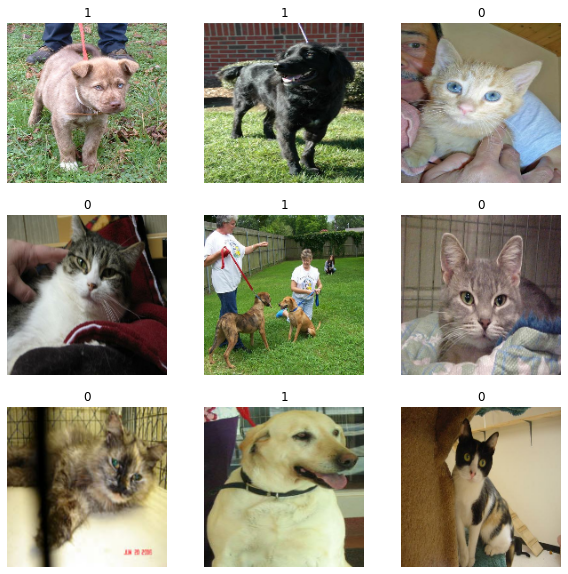

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

label 1 is "dog" and label 0 is "cat".

Using image data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
]) 

Let's visualize the augmented samples:

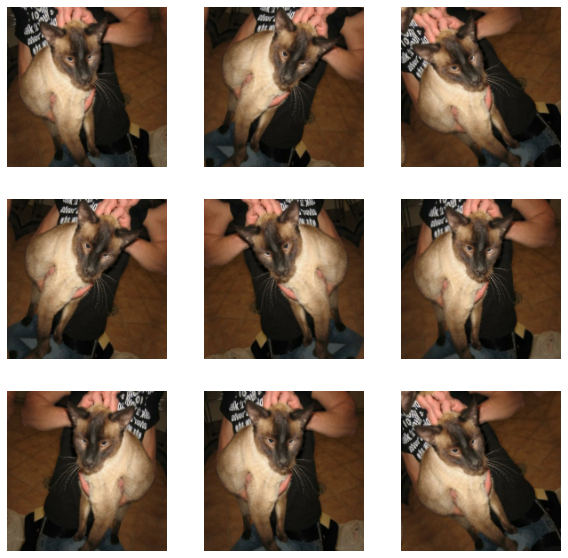

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Build a model:

1. Data_augmentation preprocessor
2. Rescaling layer
3. Dropout layer

In [ ]:
from keras import backend as K 
from keras.layers import Layer

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)  # Standardizing the data
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.experimental.preprocessing.Normalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.experimental.preprocessing.Normalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    #outputs = layers.Dense(units, activation=activation)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

Train the model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=30, callbacks=None, validation_data=val_ds,validation_steps=1)

Epoch 1/30
586/586 [==============================] - 44s 67ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6933 - val_accuracy: 0.4688
Epoch 2/30
586/586 [==============================] - 39s 66ms/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6924 - val_accuracy: 0.5625
Epoch 3/30
586/586 [==============================] - 39s 67ms/step - loss: 0.6929 - accuracy: 0.5130 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/30
586/586 [==============================] - 40s 67ms/step - loss: 0.6928 - accuracy: 0.5195 - val_loss: 0.6935 - val_accuracy: 0.5625
Epoch 5/30
586/586 [==============================] - 40s 67ms/step - loss: 0.6927 - accuracy: 0.5233 - val_loss: 0.6925 - val_accuracy: 0.5625
Epoch 6/30
586/586 [==============================] - 40s 67ms/step - loss: 0.6926 - accuracy: 0.5254 - val_loss: 0.6921 - val_accuracy: 0.4375
Epoch 7/30
586/586 [==============================] - 39s 67ms/step - loss: 0.6925 - accuracy: 0.5288 - val_loss: 0.6922 - val_accuracy:

We got 70% validation accuracy after training for 30 epochs on the full dataset.

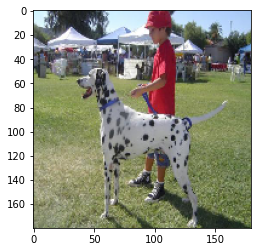

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/10004.jpg", target_size=image_size
)
plt.imshow(img)

In [ ]:
# Run inference on new data
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/10004.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 49.00 percent cat and 51.00 percent dog.
